In [ ]:
# Figure S6

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
from gcpy import single_panel
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.gridspec import GridSpec
import numpy as np
import regionmask
from scipy import stats
import seaborn as sns
import xarray as xr

from src import tools

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
def get_original_values(variable, sim, conversion_factor=1, resolution='c48'):
    MODEL_OUTPUT_DIR = "/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/"

    ds = xr.open_dataset(fr"{MODEL_OUTPUT_DIR}/GCHP.{sim}.MDA8_O3.april-august.nc4")
    da = ds[variable]*conversion_factor
    
    if "lev" in da.dims:
        da = da.isel(lev=0)
    da_monthly = da.resample(time='1M').mean(dim='time')
    #da_monthly_noland = tools.mask_ocean_c48(da_monthly)
    return da_monthly

In [5]:
# Original simulations (same function as in Fig1)
variable = "SpeciesConc_O3"
ref = get_original_values(variable, "all_ref_c48", conversion_factor=1e9, resolution='c48')
refshort = get_original_values(variable, "all_polshort_c48", conversion_factor=1e9, resolution='c48')

/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:


In [6]:
def get_map(months, present, future):
    def process_values(value, months):

        """Selects months, crops to region, removes 'region' dim, and compute total days."""
        value = value.sel(time=value.time.dt.month.isin(months))
        
        if "region" in value.dims:
            value = value.isel(region=0)

        return value.mean(dim=['time','sim'])

    # Process present and future data
    present = process_values(present, months)
    future = process_values(future, months)

    return present, future


In [7]:
# Part 2: % of O3 disbenefit days
comparison_months = [4,5,6,7,8]
present, future = get_map(comparison_months, ref, refshort)

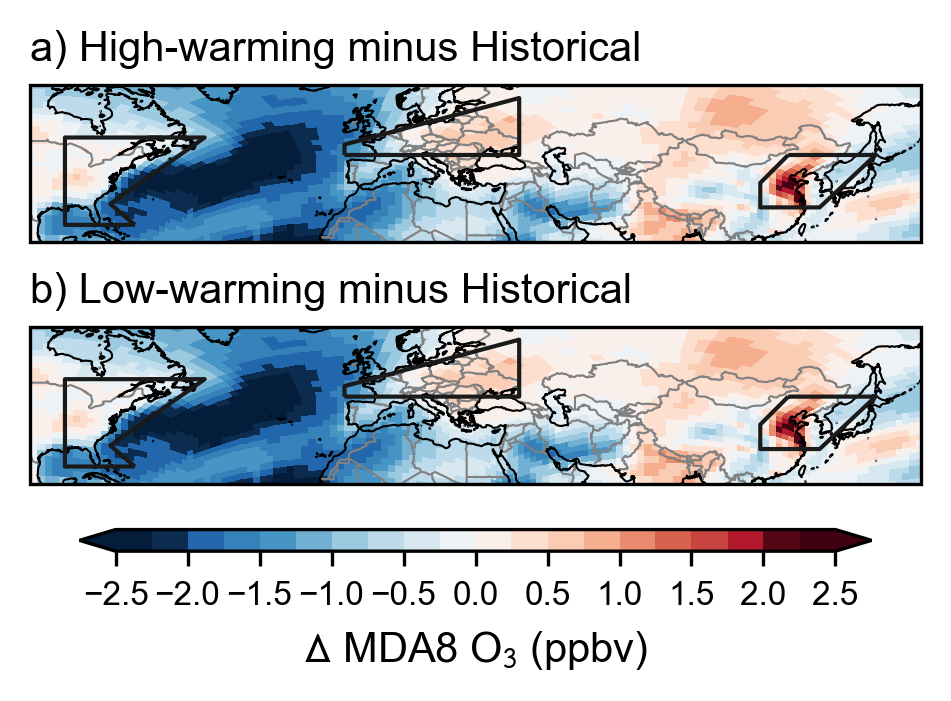

In [8]:
tools.set_matplotlib_font("Arial")

mpl.rcParams.update({
    'axes.edgecolor': 'black',      
    'xtick.color': 'black',         
    'ytick.color': 'black',         
    'xtick.labelcolor': 'black',    
    'ytick.labelcolor': 'black',    
    'grid.color': 'black',          
    'axes.labelcolor': 'black',     
    'axes.titlecolor': 'black',
    'font.size': 10, 
    'axes.titlesize': 10, 
    'axes.labelsize': 10,
    'xtick.labelsize': 10, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 10
})

fig = plt.figure(figsize=(3.3, 2.4), dpi=300)
gs1 = GridSpec(3, 1, top=0.90, bottom=0.005, left=0.05, right=0.95, hspace=0.5, wspace=0.3)
ax1 = fig.add_subplot(gs1[0, 0], projection=ccrs.PlateCarree(central_longitude=0))
ax2 = fig.add_subplot(gs1[1, 0], projection=ccrs.PlateCarree(central_longitude=0))

#################################
# Part 1. Historical spatial distribution of disbenefit days
ax = ax1

##custom colormap
#levels = np.arange(-2, 2.5, 0.25)  # includes 4.0
#n_colors = len(levels) - 1
#base_cmap = cmaps.MPL_RdBu_r
#cmap = base_cmap(np.linspace(0, 1, n_colors))
#listed_cmap = ListedColormap(cmap)
#norm = BoundaryNorm(boundaries=levels, ncolors=n_colors)

##custom colormap
levels = np.arange(-2.5, 2.75, 0.25)
n_colors = len(levels) - 1
base_cmap = cmaps.MPL_RdBu_r
colors = base_cmap(np.linspace(0, 1, n_colors))
def darken(color, factor=0.6):
    rgb = np.clip(color[:3] * factor, 0, 1)
    return np.concatenate([rgb, [color[3]]])  # keep the original alpha
colors[0] = darken(colors[0])          # below -2.25
colors[1] = darken(colors[1])          # around -2
colors[-1] = darken(colors[-1])        # above 2.25
colors[-2] = darken(colors[-2])        # around 2
listed_cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=levels, ncolors=n_colors)


plot = single_panel(plot_vals=(future-present), 
                gridtype="cs",
                ax=ax, 
                comap=listed_cmap,
                norm=norm,
                extent=(-100, 155, 20, 65), 
                vmin=-2, vmax=2,
                unit="$\Delta$ MDA8 O$_3$",
                title=None,
                add_cb=False,
                )
country_borders = cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_0_boundary_lines_land",
        scale="50m",
        facecolor="none",
    )
ax.add_feature(country_borders, edgecolor="gray", linewidth=0.5)
ax.coastlines(color="black", linewidth=0.5)

ax.set_title("a) High-warming minus Historical", loc="left", fontsize=10)

#################################
# Part 2. High-warming spatial distribution of disbenefit days
ax = ax2

plot = single_panel(plot_vals=(future-present), 
                gridtype="cs",
                ax=ax, 
                comap=listed_cmap,
                norm=norm,
                extent=(-100, 155, 20, 65), 
                vmin=-2, vmax=2,
                unit="$\Delta$ MDA8 O$_3$",
                title=None,
                add_cb=False,
                )

ax.add_feature(country_borders, edgecolor="gray", linewidth=0.5)
ax.coastlines(color="black", linewidth=0.5)

ax.set_title("b) Low-warming minus Historical", loc="left", fontsize=10)

# Add boxes around the IPCC AR6 regions
for ax in [ax1, ax2]:
    ar6 = regionmask.defined_regions.ar6.all
    ar6[5,17].plot_regions(
        ax=ax,
            add_label=False,
            line_kws=dict(lw=1),
        )

    # For EAS we use a modified polygon that captures a more homogeneous response
    new_EAS = np.array([[117,45], [109,37], [109,30], [126,30],[142,45]])
    new_EAS_region = regionmask.Regions([new_EAS], name="new_EAS")
    new_EAS_region.plot_regions(add_label=False, ax=ax, line_kws=dict(lw=1))

# Colorbar
ticks = [-2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5]
cbar_ax = fig.add_axes([0.10, 0.25, 0.80, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(plot,  
                    cax=cbar_ax, 
                    ticks=ticks, 
                    orientation="horizontal", 
                    shrink=0.50, 
                    label=r"$\Delta$ MDA8 O$_3$ (ppbv)",
                    extend='both'
                    )
cbar.ax.tick_params(labelsize=8)

plt.savefig("FigS11_v2_new.png")    

In [15]:
ar6_region = {"ENA": 5, "EAS": 58, "WCE": 17}

for region in ["ENA", "WCE", "EAS"]:
    present_noland = tools.mask_ocean_c48(present)
    future_noland = tools.mask_ocean_c48(future)

    present_EAS = tools.crop_regionmask_ar6_c48(present_noland, region_num=ar6_region[region])
    future_EAS = tools.crop_regionmask_ar6_c48(future_noland, region_num=ar6_region[region])

    # Print gridbox-level min/max percent change for NEA (="EAS")
    print(present_EAS.mean().values)
    print(future_EAS.mean().values)
    print((future_EAS.mean()-present_EAS.mean()).values)


58.71275781161012
58.429273609457574
-0.2834842021525432
53.995495052507046
54.12540325628163
0.12990820377458334
59.42343234870287
60.03096098149852
0.6075286327956491
